<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
%matplotlib inline

# not good practice, but for making it look pretty
import warnings
warnings.filterwarnings("ignore")

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [60]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-23 22:35:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-01-23 22:35:05 (10.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [61]:
raw_data = pd.read_csv('loan_train.csv')
df = raw_data.copy()
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


Let's drop the useless "Unnamed" columns and then look at general statistics for each column.

In [62]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
print(df.describe())

         Principal       terms         age
count   346.000000  346.000000  346.000000
mean    943.641618   22.653179   30.939306
std     109.425530    7.991006    6.039418
min     300.000000    7.000000   18.000000
25%     900.000000   15.000000   27.000000
50%    1000.000000   30.000000   30.000000
75%    1000.000000   30.000000   35.000000
max    1000.000000   30.000000   51.000000


We can see that there don't appear to be any outliers or missing data. Additionally, the terms field is not a continuous one, but a category that should be one-hot encoded later on.

In [63]:
df.shape

(346, 8)

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [64]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [65]:
# notice: installing seaborn might takes a few minutes -commented out so don't spend resources redoing by accident
#!conda install -c anaconda seaborn -y

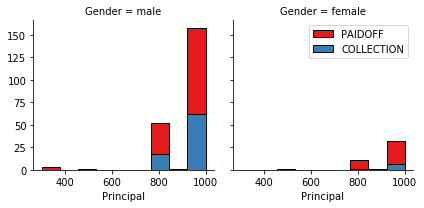

In [66]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

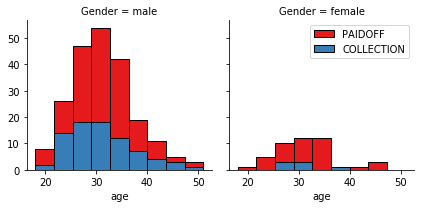

In [67]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

I have moved all of the preprocessing ato a function so that I can be sure the same transformations are used on the training and test sets. I did use the "Lets look at the day of the week people get the loan" from the original Jupyter Notebook, but had to remove the graph since the datetime conversion from above hadn't occured yet. However, the binary marker for people at the end of the week ("We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4") is used as a factor in the models.

In the three folowing functions, the first is for preprocessing the data, which includes one-hot encoding, standardization, datatype conversions, correcting spelling errors, and adding new features (such as the one mentioned above). The second function is just a graphic for the parameter optimization used in the models. The last is a k-folds function used to find the accuracy of models when optimizing the parmeters.

**Preprocessing function**: 

In [68]:
def data_prep(df):
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
    df['Gender'].replace('male',0,inplace=True)
    df['Gender'].replace('female',1,inplace=True)
    
    #one hot encode the education level and terms
    temp = df[['Principal','terms','age','Gender','weekend']].copy()
    temp = pd.concat([temp,pd.get_dummies(df['education'])], axis=1)
    temp = pd.concat([temp,pd.get_dummies(df['terms'])], axis=1)
    temp.drop(['Master or Above','terms'], axis = 1,inplace=True)
    #fix a spelling error
    temp.rename(columns = {'Bechalor':'Bachelor'}, inplace = True)

    # standardize the other numerical variables
    ss_col_names = ['Principal','age']
    ss_col = temp[ss_col_names].copy()
    scaler = preprocessing.StandardScaler().fit(ss_col.values)
    features = scaler.transform(ss_col.values)
    temp[ss_col_names] = features
    X = temp
    y = df['loan_status'].values
    return X, y


Let's separate the variables and the target using the function above:

In [69]:
X, y = data_prep(df)

**Plotting function**: 

In [70]:
def plot_trend(n, mean_acc, x_title):
    plt.plot(range(1,n),mean_acc,'g')
    plt.ylabel('Accuracy ')
    plt.xlabel(x_title)
    plt.tight_layout()
    plt.show()    

**K-folds cross-validation function**: 

In [71]:
def strat_k_folds(model_skfold,X, y):
    skfold = model_selection.StratifiedKFold(n_splits = 4)
    results_skfold = model_selection.cross_val_score(model_skfold, X, y, cv=skfold)
    return results_skfold.mean()

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

Find and store the best value of k:

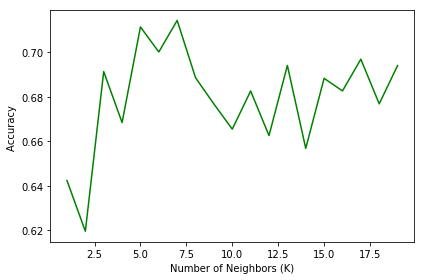

The best accuracy was  0.7144145950280674 with k= 7 



In [72]:
Ks = 20
mean_acc_knn = np.zeros((Ks-1))

for n_knn in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n_knn)    
    mean_acc_knn[n_knn-1] = strat_k_folds(neigh, X, y)

plot_trend(Ks, mean_acc_knn, 'Number of Neighbors (K)')
best_n = mean_acc_knn.argmax()+1
print( "The best accuracy was ", mean_acc_knn.max(), "with k=", best_n, '\n') 

# Decision Tree

Find and store the best tree depth:

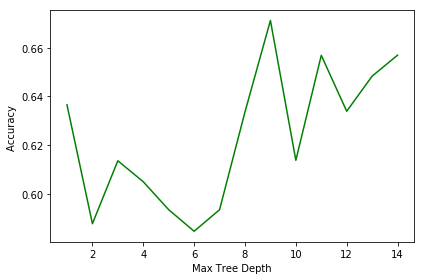

The best accuracy was  0.6712109061748196 with max_depth =  9 



In [73]:
dep = 15
mean_acc_dt = np.zeros((dep-1))

for n_dep in range(1,dep):
    #Train Model and Predict  
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n_dep)
    mean_acc_dt[n_dep-1] = strat_k_folds(loanTree, X, y) 

plot_trend(dep, mean_acc_dt, 'Max Tree Depth')
best_dep = mean_acc_dt.argmax()+1
print( "The best accuracy was ", mean_acc_dt.max(), "with max_depth = ", best_dep, '\n') 

# Support Vector Machine

Find and store the best kernel type:

In [74]:
kern = ['linear','poly','rbf','sigmoid']
mean_acc_svm = np.zeros((dep-1))

temp_acc_svm = 0
temp_max_svm = ''
for k in kern:
    svm_clf = svm.SVC(kernel=str(k),gamma='scale')
    acc = strat_k_folds(svm_clf, X, y)
    if acc > temp_acc_svm:
        temp_acc_svm = acc
        temp_max_svm = k
        
print("The best accuracy was ", temp_acc_svm, "with kernel = ", temp_max_svm, '\n') 

The best accuracy was  0.705526597166533 with kernel =  poly 



# Logistic Regression

Find and store the best solver and then (with that sover) the best value of c:

In [75]:
solv = ['newton-cg','lbfgs','liblinear']
temp_acc_lr = 0
temp_max_lr = ''
for s in solv:
    LR = LogisticRegression(C=0.25, solver=str(s))
    acc = strat_k_folds(LR, X, y)
    if acc > temp_acc_lr:
        temp_acc_lr = acc
        temp_max_lr = s
print("The best accuracy was ", temp_acc_lr, "with solver = ", temp_max_lr, '\n') 

c_test = [.01,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
mean_acc_lr = np.zeros((len(c_test)-1))
for c in range(len(c_test)):
    LR = LogisticRegression(C = c_test[c], solver = str(temp_max_lr))
    mean_acc_lr[c-1] = strat_k_folds(LR, X, y)
    
best_c = c_test[mean_acc_lr.argmax()+1]
print( "The best accuracy was ", mean_acc_lr.max(), "with c = ", best_c, '\n')    

The best accuracy was  0.7342288158246458 with solver =  newton-cg 

The best accuracy was  0.7514701951349906 with c =  0.05 



# Model Evaluation using Test set

Load jaccard_similarity_score because it has been depreciated in the newest version of scikitlearn

In [76]:
from sklearn.metrics import jaccard_similarity_score

Now that we have te best parameters based on k-folds accuracy of the training set, we need to:

1. Recreate the models using the optimal parameters and all of the training dataprepare the model for the test set
2. Predicti value for the test set using that data
3. Assess the metrics based on the predicted versus actual values

First, download and load the test set:

In [77]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-23 22:35:31--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-23 22:35:31 (336 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation and run it through the same preparation used for the training set

In [78]:
df_train = raw_data.copy()
df_train = df_train.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
X_train, y_train = data_prep(df_train)
print(X_train.shape, y_train.shape)

test_df = pd.read_csv('loan_test.csv')
test_df = test_df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
X_test, y_test = data_prep(test_df)
print(X_test.shape, y_test.shape)

(346, 10) (346,)
(54, 10) (54,)


# K Nearest Neighbor(KNN)

In [79]:
neigh_pred = KNeighborsClassifier(n_neighbors = best_n).fit(X_train, y_train)
predNeigh = neigh_pred.predict(X_test)
print('f1_score: ', metrics.f1_score(y_test, predNeigh, average='weighted'))
print('jaccard_similarity_score: ',metrics.jaccard_similarity_score(y_test, predNeigh))

f1_score:  0.6036611323967647
jaccard_similarity_score:  0.6481481481481481


# SVM

In [80]:
clf_pred = svm.SVC(kernel=str(temp_max_svm)).fit(X_train, y_train)
predClf = clf_pred.predict(X_test)
print('f1_score: ',metrics.f1_score(y_test, predClf, average='weighted'))
print('jaccard_similarity_score: ',metrics.jaccard_similarity_score(y_test, predClf))

f1_score:  0.6304176516942475
jaccard_similarity_score:  0.7407407407407407


# DecisionTree

In [81]:
loanTree_pred = DecisionTreeClassifier(criterion="entropy", max_depth = best_dep).fit(X_train, y_train)
predLoanTree = loanTree_pred.predict(X_test)
print('f1_score: ',metrics.f1_score(y_test, predLoanTree, average='weighted'))
print('jaccard_similarity_score: ',metrics.jaccard_similarity_score(y_test, predLoanTree))

f1_score:  0.7253086419753088
jaccard_similarity_score:  0.7407407407407407


# LogisticRegression

In [82]:
LR_pred = LogisticRegression(C=best_c, solver=str(temp_max_lr)).fit(X_train, y_train)
predLR = LR_pred.predict(X_test)
predLR_prob = LR_pred.predict_proba(X_test)
print('f1_score: ',metrics.f1_score(y_test, predLR, average='weighted'))
print('jaccard_similarity_score: ',metrics.jaccard_similarity_score(y_test, predLR))
print('log_loss: ',metrics.log_loss(y_test, predLR_prob))

f1_score:  0.6304176516942475
jaccard_similarity_score:  0.7407407407407407
log_loss:  0.506058878966539


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.64815 | 0.60366  | NA      |
| Decision Tree      | 0.74074 | 0.72531  | NA      |
| SVM                | 0.74074 | 0.63042  | NA      |
| LogisticRegression | 0.74074 | 0.63042  | 0.50606 |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>